In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
import html
%matplotlib inline

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Goal:  Predict how many Citibike Rides will be taken on a given day

In [2]:
#Read in existing data: https://www.citibikenyc.com/system-data
jan_mar_2018 = pd.read_csv('~/downloads/data-7OLX8.csv')


days_dict = {0: 'Monday',
            1: 'Tuesday',
            2: 'Wednesday',
            3: 'Thursday',
            4: 'Friday',
            5: 'Saturday',
            6: 'Sunday'}

jan_mar_2018['weekday'] = pd.to_datetime(jan_mar_2018['Date']).dt.dayofweek.map(days_dict)

jan_mar_2018.head(10)

#df['weekday'] = df['Timestamp'].dt.dayofweek
#datetime.datetime.today().weekday()

,Date,Trips over the past 24-hours (midnight to 11:59pm),Miles traveled today (midnight to 11:59 pm),Total Annual Members (All Time),24-Hour Passes Purchased (midnight to 11:59 pm),3-Day Passes Purchased (midnight to 11:59 pm),weekday
0,1/1/2018,5499,11483,253490,123,7,Monday
1,1/2/2018,18818,39352,253558,125,12,Tuesday
2,1/3/2018,24299,42853,253591,164,4,Wednesday
3,1/4/2018,1922,5328,253604,2,1,Thursday
4,1/5/2018,4972,14303,253614,14,0,Friday
5,1/6/2018,4294,9479,253624,9,2,Saturday
6,1/7/2018,5640,9387,253640,41,4,Sunday
7,1/8/2018,15820,31294,253661,45,4,Monday
8,1/9/2018,25090,50981,253690,112,17,Tuesday
9,1/10/2018,28252,50218,253720,142,18,Wednesday


In [3]:
#Next, add in weather data.
#Importing csv from noaa
weather_df = pd.read_csv('~/downloads/1360856.csv')
#weather_df.NAME.unique()
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df = weather_df[(weather_df['NAME']=='LA GUARDIA AIRPORT, NY US') & (weather_df['DATE'] >= '2018-01-01') & (weather_df['DATE'] <= '2018-03-31')]

#Reduce to the variables we care about
weather_df = weather_df[['DATE', 'PRCP', 'SNOW','TAVG', 'TMAX', 'TMIN']]
weather_df.head(10)

,DATE,PRCP,SNOW,TAVG,TMAX,TMIN
2763,2018-01-01,0.00,0.0,13.0,19.0,8.0
2764,2018-01-02,0.00,0.0,18.0,26.0,14.0
2765,2018-01-03,0.00,0.0,23.0,30.0,17.0
2766,2018-01-04,0.51,7.4,26.0,29.0,20.0
2767,2018-01-05,0.00,0.0,17.0,20.0,10.0
2768,2018-01-06,0.00,0.0,12.0,15.0,8.0
2769,2018-01-07,0.00,0.0,11.0,18.0,6.0
2770,2018-01-08,0.00,0.0,22.0,33.0,18.0
2771,2018-01-09,0.00,0.0,35.0,43.0,30.0
2772,2018-01-10,0.00,0.0,34.0,40.0,26.0


In [4]:
#Merge weather dataframe with ride dataframe
jan_mar_2018['Date'] = pd.to_datetime(jan_mar_2018['Date'])
combined_df = pd.merge(jan_mar_2018,weather_df, left_on='Date', right_on = 'DATE')
combined_df.head(10)

,Date,Trips over the past 24-hours (midnight to 11:59pm),Miles traveled today (midnight to 11:59 pm),Total Annual Members (All Time),24-Hour Passes Purchased (midnight to 11:59 pm),3-Day Passes Purchased (midnight to 11:59 pm),weekday,DATE,PRCP,SNOW,TAVG,TMAX,TMIN
0,2018-01-01,5499,11483,253490,123,7,Monday,2018-01-01,0.00,0.0,13.0,19.0,8.0
1,2018-01-02,18818,39352,253558,125,12,Tuesday,2018-01-02,0.00,0.0,18.0,26.0,14.0
2,2018-01-03,24299,42853,253591,164,4,Wednesday,2018-01-03,0.00,0.0,23.0,30.0,17.0
3,2018-01-04,1922,5328,253604,2,1,Thursday,2018-01-04,0.51,7.4,26.0,29.0,20.0
4,2018-01-05,4972,14303,253614,14,0,Friday,2018-01-05,0.00,0.0,17.0,20.0,10.0
5,2018-01-06,4294,9479,253624,9,2,Saturday,2018-01-06,0.00,0.0,12.0,15.0,8.0
6,2018-01-07,5640,9387,253640,41,4,Sunday,2018-01-07,0.00,0.0,11.0,18.0,6.0
7,2018-01-08,15820,31294,253661,45,4,Monday,2018-01-08,0.00,0.0,22.0,33.0,18.0
8,2018-01-09,25090,50981,253690,112,17,Tuesday,2018-01-09,0.00,0.0,35.0,43.0,30.0
9,2018-01-10,28252,50218,253720,142,18,Wednesday,2018-01-10,0.00,0.0,34.0,40.0,26.0


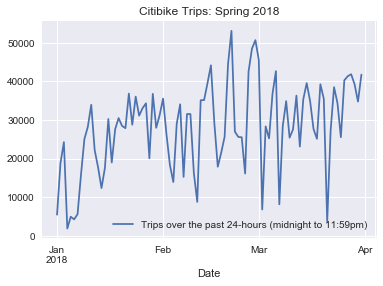

In [5]:
#Plots
#Line Graph:  Date vs. Number of Trips
combined_df.plot.line(x='Date', y='Trips over the past 24-hours (midnight to 11:59pm)', title='Citibike Trips: Spring 2018')

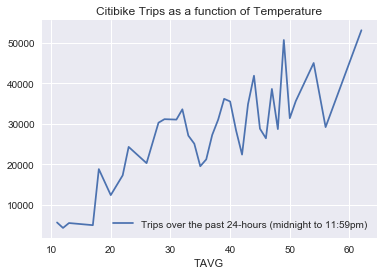

In [6]:
#What matters more:  Temperature or precipitation?
#Plot for temperature
combined_df.groupby(['TAVG']).mean().plot.line(y='Trips over the past 24-hours (midnight to 11:59pm)', title='Citibike Trips as a function of Temperature')


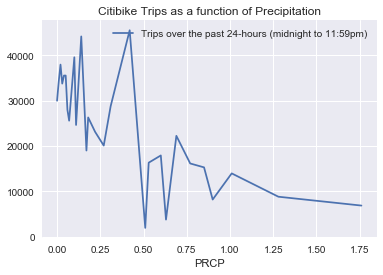

In [7]:
#Plot for precipitation
combined_df.groupby(['PRCP']).mean().plot.line(y='Trips over the past 24-hours (midnight to 11:59pm)', title='Citibike Trips as a function of Precipitation')

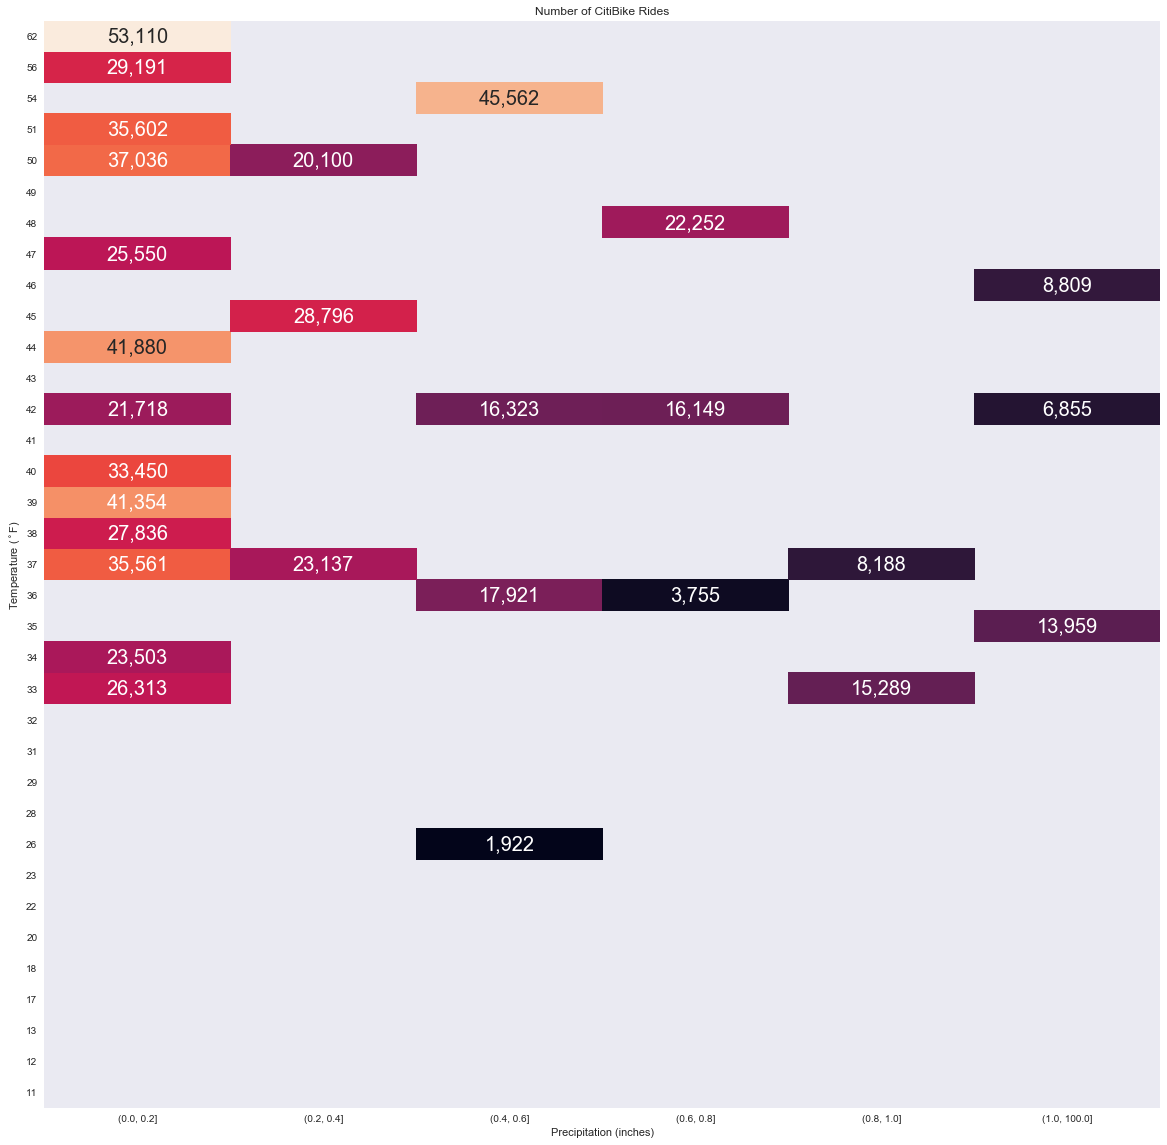

In [8]:
combined_df['Precip_Bin'] = pd.cut(combined_df['PRCP'],[0,0.2,0.4,0.6,0.8,1,100])
combined_df['TAVG'] = combined_df['TAVG'].astype(int)
combined_dfmod = pd.pivot_table(combined_df, values='Trips over the past 24-hours (midnight to 11:59pm)', index=['TAVG'], columns=['Precip_Bin'])
combined_dfmod.head(10)
pyplot.figure(figsize=(20,20))
ax = sns.heatmap(combined_dfmod, cbar=False, annot=True, annot_kws={"size": 20}, fmt=',.0f')
ax.set(xlabel='Precipitation (inches)', ylabel = 'Temperature ($^\circ$F)', title='Number of CitiBike Rides')
loc, labels = pyplot.yticks()
ax.set_yticklabels(labels[::1],rotation=0)
sns.set(font_scale=2)
ax.invert_yaxis()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  import sys


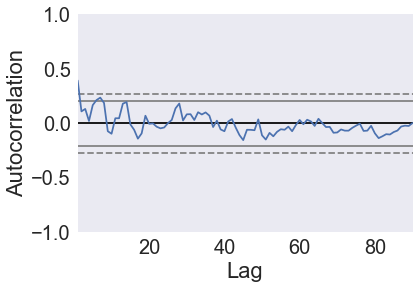

In [9]:
#Check for autocorrelation
#new = old.filter(['A','B','D'], axis=1)
combined_df_times = combined_df.filter(['Date','Trips over the past 24-hours (midnight to 11:59pm)'], axis=1)
combined_df_times.set_index('Date',drop=True,inplace=True)
combined_df_times.head(10)
#combined_df_times.plot()
autocorrelation_plot(combined_df_times)
plt.show()

Citibike data does not appear to be autocorrelated.

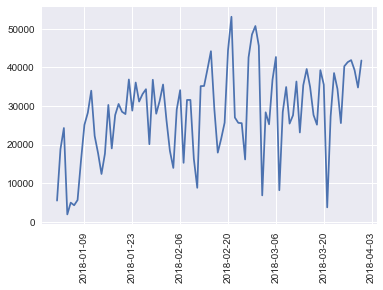

In [10]:
#Next, let's check for stationarity 
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.xticks(rotation=90)
plt.plot(combined_df_times)

Here we can see that there is an increasing trend; the number of rides is not stationary.  Let's use a log transform and use a moving average to make it stationary.

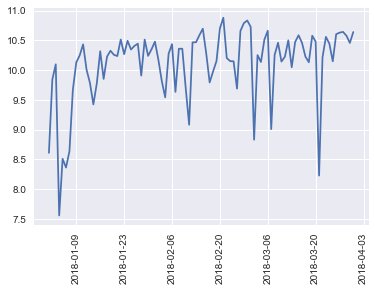

In [11]:
combined_df_times_log = np.log(combined_df_times)
plt.xticks(rotation=90)
pyplot.plot(combined_df_times_log)

In [12]:
moving_avg = combined_df_times_log.rolling(window=7,center=False).mean()

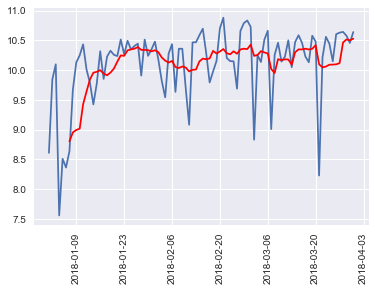

In [13]:
pyplot.plot(combined_df_times_log)
plt.xticks(rotation=90)
pyplot.plot(moving_avg, color='red')

In [14]:
combined_df_log_moving_avg_diff = combined_df_times_log - moving_avg
combined_df_log_moving_avg_diff.head(7)

,Trips over the past 24-hours (midnight to 11:59pm)
Date,
2018-01-01,NaN
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN
2018-01-06,NaN
2018-01-07,-0.166417


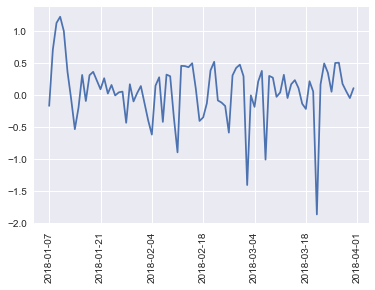

In [15]:
combined_df_log_moving_avg_diff.dropna(inplace=True)
plt.xticks(rotation=90)
pyplot.plot(combined_df_log_moving_avg_diff)

This is much closer to stationary than before.

In [16]:
df_for_forecast = pd.merge(combined_df, combined_df_log_moving_avg_diff,
      left_on='Date', right_index=True,
      suffixes=('_x', '_y'))

In [17]:
df_for_forecast.head()

,Date,Trips over the past 24-hours (midnight to 11:59pm)_x,Miles traveled today (midnight to 11:59 pm),Total Annual Members (All Time),24-Hour Passes Purchased (midnight to 11:59 pm),3-Day Passes Purchased (midnight to 11:59 pm),weekday,DATE,PRCP,SNOW,TAVG,TMAX,TMIN,Precip_Bin,Trips over the past 24-hours (midnight to 11:59pm)_y
6,2018-01-07,5640,9387,253640,41,4,Sunday,2018-01-07,0.0,0.0,11,18.0,6.0,NaN,-0.166417
7,2018-01-08,15820,31294,253661,45,4,Monday,2018-01-08,0.0,0.0,22,33.0,18.0,NaN,0.714016
8,2018-01-09,25090,50981,253690,112,17,Tuesday,2018-01-09,0.0,0.0,35,43.0,30.0,NaN,1.134116
9,2018-01-10,28252,50218,253720,142,18,Wednesday,2018-01-10,0.0,0.0,34,40.0,26.0,NaN,1.231279
10,2018-01-11,33961,66584,253757,244,15,Thursday,2018-01-11,0.0,0.0,40,47.0,35.0,NaN,1.005063


In [18]:
df_for_forecast['weekday'] = df_for_forecast['weekday']

weekend_dict = {'Monday': 0,
            'Tuesday': 0,
            'Wednesday': 0,
            'Thursday': 0,
            'Friday': 0,
            'Saturday': 1,
            'Sunday': 1}

df_for_forecast['is_weekend'] = df_for_forecast['weekday'].map(weekend_dict)

In [21]:
#Regression
#Need to handle weekday appropriately
#See this:  https://blog.datarobot.com/multiple-regression-using-statsmodels

df_for_forecast['weekday_ord'] = pd.Categorical(df_for_forecast.is_weekend).labels
df_for_forecast['log_diff_trips'] = df_for_forecast['Trips over the past 24-hours (midnight to 11:59pm)_y']

est = smf.ols(formula="log_diff_trips ~ weekday_ord + PRCP + SNOW + TMAX", data=df_for_forecast).fit()

print est.summary().tables[1]


                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0790      0.145     -0.543      0.588      -0.368       0.210
weekday_ord    -0.3070      0.066     -4.658      0.000      -0.438      -0.176
PRCP           -0.7985      0.099     -8.049      0.000      -0.996      -0.601
SNOW           -0.1551      0.030     -5.239      0.000      -0.214      -0.096
TMAX            0.0082      0.003      2.685      0.009       0.002       0.014


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  """


In [37]:
def forecast_new_value(RA, weekday_ord, PRCP, SNOW, TMAX):
    logRA = np.log(RA)
    raw_predict_diff = -0.790 + -0.3070*weekday_ord - .7985*PRCP + -.1551*SNOW + .0082*TMAX
    raw_predict = logRA - raw_predict_diff
    final_predict = np.exp(raw_predict)
    #print "log RA is %s" %logRA
    #print("raw_predict_diff is %s" %raw_predict_diff)
    #print("raw_predict is %s" %raw_predict)
    return final_predict

In [39]:
#Test prediction function:
print forecast_new_value(10000, 0, 0,0,50)

14622.84589434227
